### Extract a Shell Mass Region  

In [1]:
%matplotlib inline
import shell_model
import astropy.units as u
from astropy.coordinates import SkyCoord
import shells
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion
from spectral_cube import SpectralCube
dist = 414*u.pc

In [2]:
# BEST-FIT PARAMETERS FOR SHELL 18
r = 0.17 * u.pc
dr = 0.25 * u.pc
vexp = 4 * u.km/u.s
v0 = 14.25 * u.km/u.s
shell_center = SkyCoord("5h34m54.496s","-5d04m40.05s")
ra, dec = shell_center.ra, shell_center.dec
r_angle = (r / dist) * u.radian
dr_angle = (dr / dist) * u.radian

100611129.93136448 K km / s


(82, 40, 39)

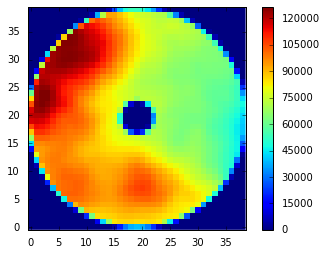

In [3]:
cube = SpectralCube.read(
    "../nro_maps/12CO_20161002_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms.fits").subcube(
        ra + r_angle + dr_angle / 2.,
        ra - r_angle - dr_angle / 2.,
        dec - r_angle - dr_angle / 2.,
        dec + r_angle + dr_angle / 2.,
        v0 - vexp,
        v0 + vexp
        )
#print(cube)
mom0 = cube.moment0()

inner = CircleSkyRegion(
    center=shell_center,
    radius=r_angle - dr_angle / 2.
    ).to_pixel(mom0.wcs).to_mask(mode='exact').to_image(mom0.shape)

outer = CircleSkyRegion(
    center=shell_center,
    radius=r_angle + dr_angle / 2.,
    ).to_pixel(cube.wcs).to_mask(mode='exact').to_image(mom0.shape)
annulus = outer - inner
plt.imshow(annulus*mom0.data, interpolation='none')
plt.colorbar()
print(np.sum(annulus*mom0.data)*u.K*u.km/u.s)
shell_voxels = np.array([annulus*cube[i,:,:].data for i in range(cube.shape[0])])
shell_voxels.shape


In [4]:
def extract_shell(cube=None, ra=None, dec=None,
    r=None, dr=None, vexp=None, v0=None, mask_mode='exact', dist=414*u.pc,
    subtract_inner=True):
    """
    As written, simply extracts a hollow cylinder from the cube
    with annulus defined by the r and dr
    and depth in velocity space by vexp and v0.
    This will include too much emission at 
    the extreme velocity ends of the shell. Will give upper limits
    to shell mass, kinetic energy, and momentum.
    
    Returns
    -------
    Array of all voxels inside shell mass region and the mask array
    used to extract the shell voxels.
    """
    
    r_angle = (r / dist) * u.radian
    dr_angle = (dr / dist) * u.radian
    
    cube = SpectralCube.read(cube).subcube(
        ra + r_angle + dr_angle / 2.,
        ra - r_angle - dr_angle / 2.,
        dec - r_angle - dr_angle / 2.,
        dec + r_angle + dr_angle / 2.,
        v0 - vexp,
        v0 + vexp
        )
    
    #mom0 = cube.moment0()
    
    center = SkyCoord(ra, dec)
    r_angle = u.rad * r / dist
    dr_angle = u.rad * dr / dist
    
    mask_inner = CircleSkyRegion(
        center=center,
        radius=r_angle - dr_angle / 2.
    ).to_pixel(cube.wcs).to_mask(mode=mask_mode).to_image(mom0.shape)
    mask_outer = CircleSkyRegion(
        center=center,
        radius=r_angle + dr_angle / 2.
    ).to_pixel(cube.wcs).to_mask(mode=mask_mode).to_image(mom0.shape)
    
    if subtract_inner:
        mask_annulus = mask_outer - mask_inner
    else:
        mask_annulus = mask_outer
        
    shell_voxels = np.array([mask_annulus*cube[i,:,:].data for i in range(cube.shape[0])])
    return shell_voxels, mask_annulus



## Using a Shell Model Cube as Mask to Extract Shell Voxels
Use a model cube of a shell with parameters r, dr, v0, vexp matched to an observed cube. Make a mask from the model cube, to select only voxels with non-zero values in the model shell. Apply the mask cube to the observed cube to extract only the voxels in the shell. Do this for any number of sets of parameters within the estimated parameter ranges of the shell.

Using SpectralCube Masking: http://spectral-cube.readthedocs.io/en/latest/masking.html


#### Shell 18

In [5]:
n=17
shell_list = shells.get_shells()
shell = shell_list[n]
#Best-fit parameters from Shell Scores spreadsheet
#https://docs.google.com/spreadsheets/d/1rq-UZuP2PbDR9wb6woCT65GQI74NdyIJ5aWQ3CXsDhI/
r = 0.17 * u.pc
dr = 0.05 * u.pc
vexp = 4 * u.km/u.s
v0 = 14.25 * u.km/u.s
dist = 414*u.pc

model_pars = {
    'dist':dist, # pc
    'pix_size':7.5*u.arcsec, # arcsec
    'vstep':0.099*u.km/u.s, # km/s
    'acen':shell.ra, # deg
    'dcen':shell.dec, # deg
    'thickness':0.0, # pc
    'fwhm':0.0, # km/s
    'beta':0.0, # spectral index
    'R':r, # pc
    'dr':dr, # pc
    'vexp':vexp, # km/s
    'depth_offset':0.0, # pc
    'vel_offset':0.0, # km/s
    'v0':v0, # km/s
    'ignore_cloud':1, #Ignore cloud.
    'method':'sample',
    'write_fits':False,
    'samples_per_voxel':27}
model_cube = SpectralCube.read(shell_model.ppv_model(**model_pars))

In [6]:
cube_file = "../nro_maps/12CO_20161002_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms.fits"
obs_cube = SpectralCube.read(cube_file).subcube(
                                model_cube.longitude_extrema[1],
                                model_cube.longitude_extrema[0],
                                model_cube.latitude_extrema[0],
                                model_cube.latitude_extrema[1],
                                model_cube.spectral_extrema[0],
                                model_cube.spectral_extrema[1])
#Reset the cube wcs to the values corresponding to the subcube.
obs_cube = SpectralCube(obs_cube.hdu.data, wcs=model_cube.wcs) * u.K

In [7]:
assert model_cube.shape == obs_cube.shape

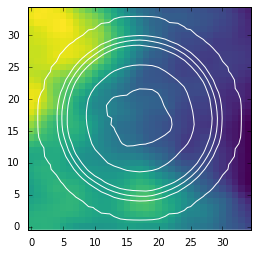

In [8]:
plt.imshow(obs_cube.moment0().data, interpolation='none', cmap='viridis')
plt.contour(model_cube.moment0().data, np.linspace(0.01, np.nanmax(model_cube.moment0().data), 5),
            colors='white')

### Make a mask out of Model Cube with True where Model_cube > 0.

In [9]:
shell_mask = model_cube > 0.00001*u.dimensionless_unscaled
#print(obs_cube.wcs, model_cube.wcs)
#obs_cube_masked = obs_cube.with_mask(shell_mask)

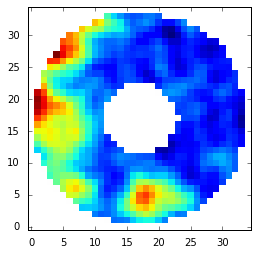

In [10]:
obs_cube_masked = obs_cube.with_mask(shell_mask)
obs_array_masked = obs_cube_masked.filled_data[:,:,:]
plt.imshow(obs_cube_masked[40].data, interpolation='none')

## IT WORKED!

### Calculate RMS of Emission-free channels


In [11]:
def rms_map(cube=None, velocity_range=[[-3.,-0.1], [19.,20.]]*u.km/u.s):
    """
    Returns 2D array of the standard deviation of a spectral cube,
    calculated only in the emission-free channels.
    """
    cube.filled_data[:,:,:]
    channel_range = [[cube.closest_spectral_channel(vpair[0]),
                  cube.closest_spectral_channel(vpair[1])]
                 for vpair in velocity_range]

    emissionless_channels = np.concatenate([np.arange(c[0], c[1]+1) for c in channel_range])
    print(len(emissionless_channels))
    #print(emissionless_channels)
    emissionless_cube = cube.unmasked_data[emissionless_channels,:,:]
    rms_map = np.nanstd(emissionless_cube, axis=0)
    return rms_map

30


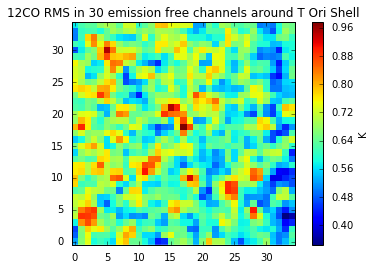

In [12]:
nro_12co = "../nro_maps/12CO_20170514_FOREST-BEARS_spheroidal_grid7.5_dV0.099kms_xyb_YS.fits"
subcube_shell = SpectralCube.read(nro_12co).subcube(
        obs_cube_masked.longitude_extrema[1],
        obs_cube_masked.longitude_extrema[0],
        obs_cube_masked.latitude_extrema[0],
        obs_cube_masked.latitude_extrema[1])
plt.imshow(rms_map(cube=subcube_shell).value, interpolation='none')
plt.colorbar(label="K")
plt.title('12CO RMS in 30 emission free channels around T Ori Shell')

30


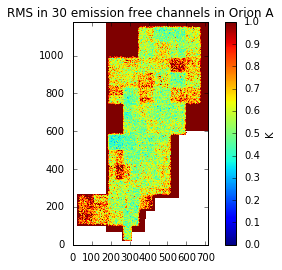

In [13]:
plt.imshow(rms_map(
        cube=SpectralCube.read(nro_12co)).value,
           interpolation='none', vmin=0, vmax=1)
plt.colorbar(label="K")
plt.title('RMS in 30 emission free channels in Orion A')

### 12CO/13CO Intensity ratio
Compute the 12CO/13CO intensity ratio. 

#### Regrid 13CO cube.
We need the two cubes on the same velocity grid. First we need to smooth the cube with finer spectral resolution to the coarser cube and interpolate onto the same spectral axis as the coarser cube. In the case of NRO cubes 12CO_20170518 and 13CO_20170514, the cubes have the same velocity resolution. The 13CO cube just has 10 more channels at the high velocity end than 12CO. So we'll just remove these channels from the 13CO cube.

I wrote a `regrid` function in `physics.py` module to do the smoothing and interpolation, but here I will just directly write out the corrected 13CO cube.

In [14]:
cube_13co = SpectralCube.read("../nro_maps/13CO_20170518_FOREST-BEARS_spheroidal_grid7.5_dV0.11kms_xyb_YS.fits")
cube_12co = SpectralCube.read("../nro_maps/12CO_20170514_FOREST-BEARS_spheroidal_grid7.5_dV0.099kms_xyb_YS.fits")
print("13co has a velocity resolution of {}.".format(cube_13co.spectral_axis[1] - cube_13co.spectral_axis[0]))
print(cube_13co)
print("12co has a velocity resolution of {}".format(cube_12co.spectral_axis[1] - cube_12co.spectral_axis[0]))
print(cube_12co)

13co has a velocity resolution of 99.0 m / s.
SpectralCube with shape=(232, 1180, 716) and unit=K:
 n_x:    716  type_x: RA---SFL  unit_x: deg    range:    83.271120 deg:   84.772625 deg
 n_y:   1180  type_y: DEC--SFL  unit_y: deg    range:    -7.224700 deg:   -4.768450 deg
 n_s:    232  type_s: VOPT      unit_s: m / s  range:    -1950.500 m / s:   20918.500 m / s
12co has a velocity resolution of 99.0 m / s
SpectralCube with shape=(222, 1180, 716) and unit=K:
 n_x:    716  type_x: RA---SFL  unit_x: deg    range:    83.271120 deg:   84.772625 deg
 n_y:   1180  type_y: DEC--SFL  unit_y: deg    range:    -7.224700 deg:   -4.768450 deg
 n_s:    222  type_s: VOPT      unit_s: m / s  range:    -1950.500 m / s:   19928.500 m / s


In [15]:
#cube_13co_regrid = cube_13co.spectral_interpolate(cube_12co.spectral_axis)
cube_13co_regrid

NameError: name 'cube_13co_regrid' is not defined

In [16]:
#c = SpectralCube(cube_13co_regrid.hdu.data, wcs=cube_12co.wcs)

In [17]:
#cube_13co_regrid.write("cube_13co_regrid.fits")

### 12CO/13CO Intensity ratio cubes
Compute the 12CO/13CO intensity ratio. 

In [18]:
nro_12co = '../nro_maps/12CO_20170514_FOREST-BEARS_spheroidal_grid7.5_dV0.099kms_xyb_YS.fits'
nro_13co = '../nro_maps/13CO_20170518_FOREST-BEARS_spheroidal_grid7.5_dV0.11kms_xyb_YS_regridto12CO.fits'

subcube_shell_12co = SpectralCube.read(nro_12co).subcube(
        obs_cube_masked.longitude_extrema[1],
        obs_cube_masked.longitude_extrema[0],
        obs_cube_masked.latitude_extrema[0],
        obs_cube_masked.latitude_extrema[1])
subcube_shell_13co = SpectralCube.read(nro_13co).subcube(
        subcube_shell_12co.longitude_extrema[1],
        subcube_shell_12co.longitude_extrema[0],
        subcube_shell_12co.latitude_extrema[0],
        subcube_shell_12co.latitude_extrema[1])

In [158]:
rms_map_12co = rms_map(cube=subcube_shell_12co)
rms_map_13co = rms_map(cube=subcube_shell_13co)

mask_both_5sig = (subcube_shell_13co > 5*rms_map_13co) & (subcube_shell_12co > 5*rms_map_12co)
subcube_shell_13co_5sig = subcube_shell_13co.with_mask(mask_both_5sig)
#c = subcube_shell_13co.with_mask(subcube_shell_13co > 5*rms_map_13co)
#c = c.with_mask(subcube_shell_12co > 5*rms_map_12co)
subcube_shell_12co_5sig = subcube_shell_12co.with_mask(mask_both_5sig)
#plt.imshow(subcube_shell_13co_5sig[120,:,:].data)

30
30


In [20]:
ratio_5sig = subcube_shell_12co_5sig / subcube_shell_13co_5sig
#print(np.mean(ratio.unmasked_data[:,:,:]))

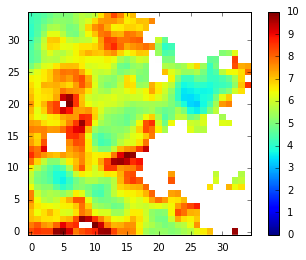

In [151]:
plt.imshow(ratio_5sig[120,:,:].data, interpolation='none', vmin=0, vmax=10)
plt.colorbar()

### Calculate Weights for Weighted Average and Standard Deviation of Ratio in Each Channel
The uncertainty on the ratio is calculated via error propagation. This is used to weight the averages and 
standard deviations of the ratio in each channel.

In [160]:
sigma_ratio_5sig = ratio_5sig * np.sqrt((rms_map_12co / subcube_shell_12co_5sig)**2.
                                        + (rms_map_13co / subcube_shell_13co_5sig)**2.)
weights = 1./(sigma_ratio_5sig.filled_data[:,:,:]**2.)


TypeError: unsupported operand type(s) for /: 'float' and 'SpectralCube'

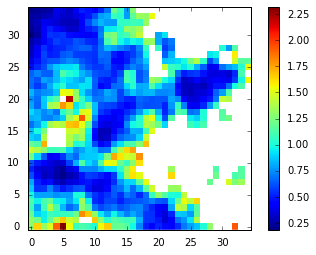

In [152]:
plt.imshow(sigma_ratio_5sig[120,:,:].data, interpolation='none')
plt.colorbar()

### Weighted Average and Standard Deviation of Ratio in Each Channel

In [66]:
#ratio_weighted_average = [np.average(ratio_5sig[i], weights=1./(sigma_ratio_5sig[i])**2.).value
#                          for i in range(ratio_5sig.shape[0])]
#ratio_weighted_std = [np.average(ratio_5sig[i], weights=1./(sigma_ratio_5sig[i])**2.).value
#                          for i in range(ratio_5sig.shape[0])]
ratio_weighted_average = np.average(ratio_5sig.filled_data[:,:,:], weights=weights, axis=(1,2))  
resids_squared = (ratio_5sig - ratio_weighted_average[:,np.newaxis,np.newaxis])**2.
ratio_weighted_std = np.sqrt(np.average(resids_squared, weights=weights, axis=(1,2)))

### Plot and fit average ratio with quadratic

Best-fit: (1.3 +/- 0.007) x (vel [km/s])**2 + (-29.0 +/- 4.0) x (vel [km/s]) + (170.0 +/- 110.0)


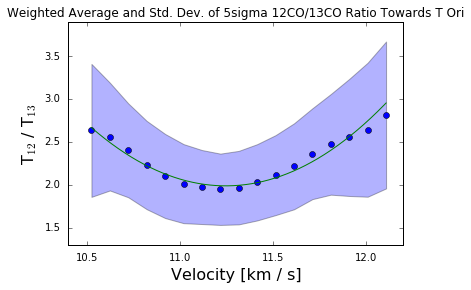

In [150]:
notnan = ~np.isnan(ratio_weighted_average)
vel = ratio_5sig.spectral_axis.to(u.km/u.s).value
fit_coeff, fit_cov = np.polyfit(vel[notnan], ratio_weighted_average[notnan], 2, w=(1/ratio_weighted_std[notnan]), cov=True)
#plt.errorbar(vel, ratio_weighted_average, ratio_weighted_std,
#             marker='o')
plt.plot(vel, ratio_weighted_average, 'o')
p = np.poly1d(fit_coeff)
xfit = np.linspace(vel[notnan][0], vel[notnan][-1], 1000)
yfit = p(xfit)
print("Best-fit: ({} +/- {}) x (vel [km/s])**2 + ({} +/- {}) x (vel [km/s]) + ({} +/- {})".format(
        round(fit_coeff[0],3), round(fit_cov[0,0],3),
        round(fit_coeff[1],0), round(fit_cov[1,1],0),
        round(fit_coeff[2], -1), round(fit_cov[2,2],-1)))
plt.plot(xfit, yfit)
plt.fill_between(vel,
    ratio_weighted_average+ratio_weighted_std, ratio_weighted_average-ratio_weighted_std,
                alpha=0.3)
plt.ylabel(r"T$_{12}$ / T$_{13}$", size=16)
plt.xlabel("Velocity [km / s]", size=16)
plt.ylim(1.3,3.9)
plt.title("Weighted Average and Std. Dev. of 5sigma 12CO/13CO Ratio Towards T Ori")
plt.savefig("shell_ratio_fit.png")